### Learning, Information and Knowledge Systems Lab, SEAS, Harvard University
### Hsiang Hsu
#### hsianghsu@g.harvard.edu

# Bottleneck Problem

**Fall 2017**<br/>
**Instructors**: Professor Flavio Calmon

---

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import math
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import ConvexHull
from scipy.optimize import fsolve, linprog
from numpy.linalg import norm, inv, matrix_power
from scipy.integrate import simps
from scipy.linalg import sqrtm, svd
from sympy import Matrix

## Mrs. and Mr. Gerber's Lemma

In [16]:
''' Helper Functions '''
# Binary Entropy Function
def hb(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p*np.log2(p)-(1-p)*np.log2(1-p)

# Binary Entropy Inverted Function
def hbv(h):
    f = lambda x: x**x * (1-x)**(1-x) - 2**(-h)
    return fsolve(f, 0)

# Complement Multiplication Operator
def star(a, b):
    return (1-a)*b+(1-b)*a


def MSGL_L(x, delta):
    return hb(star(delta, hbv(x)))
def MSGL_U(x, delta, q):
    f = lambda a: x- a*hb(q/max(a, 2*q))
    a = fsolve(f, 0.5)
    return a*hb(star(q/max(a, 2*q), delta)) + (1-a)*hb(delta)
    

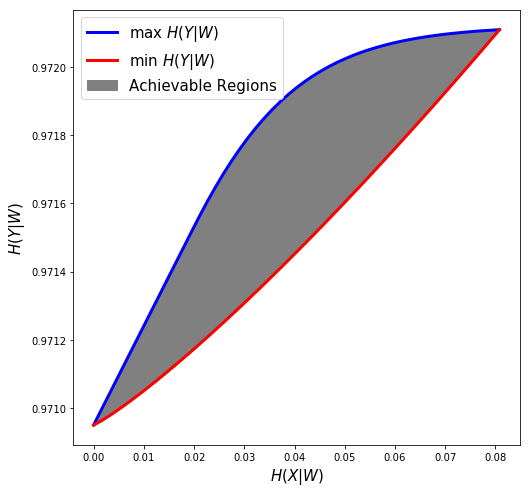

In [17]:
# crossover probability
delta = 0.4
#
q = 0.01

x = np.linspace(0, hb(q), 51)
MSGL_upper = []
MSGL_lower = []
for i in range(len(x)):
    MSGL_upper.append(MSGL_U(x[i], delta, q)[0])
    MSGL_lower.append(MSGL_L(x[i], delta)[0])
plt.figure(figsize=(8, 8))
plt.plot(x, MSGL_upper, 'b-', label='$\max\ H(Y|W)$', linewidth=3)
plt.plot(x, MSGL_lower, 'r-', label='$\min\ H(Y|W)$', linewidth=3)
plt.fill_between(x, MSGL_lower, MSGL_upper, color='gray', label='Achievable Regions')
plt.xlabel('$H(X|W)$', fontsize = 15)
plt.ylabel('$H(Y|W)$', fontsize = 15)
plt.legend(loc='best', fontsize=15)

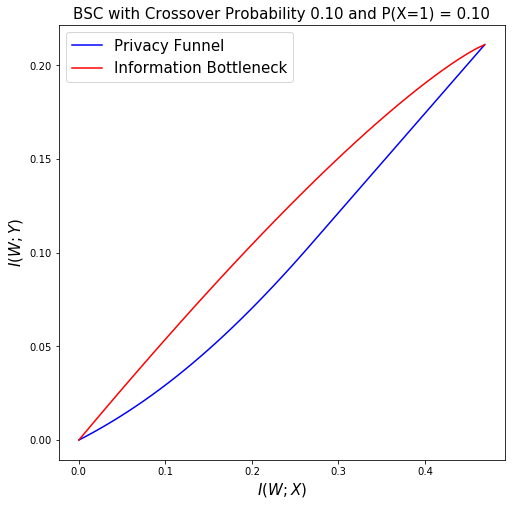

In [18]:
# crossover probability
delta = 0.1
# 
q = 0.1

x = np.linspace(0, hb(q), 51)
I_WX = []
I_WY_min = []
I_WY_max = []
for i in range(len(x)):
    I_WX.append(hb(q) - x[i])
    I_WY_min.append(hb(star(q, delta)) - MSGL_U(x[i], delta, q))
    I_WY_max.append(hb(star(q, delta)) - MSGL_L(x[i], delta))
 
plt.figure(figsize=(8, 8))
plt.plot(I_WX, I_WY_min, 'b-', label='Privacy Funnel')
plt.plot(I_WX, I_WY_max, 'r-', label='Information Bottleneck')
plt.xlabel('$I(W; X)$', fontsize = 15)
plt.ylabel('$I(W; Y)$', fontsize = 15)
plt.legend(loc='best', fontsize=15)
plt.title('BSC with Crossover Probability %.2f and P(X=1) = %.2f'%(delta, q), fontsize=15)

## IB and PF in $\chi^2$ divergence

In [14]:
def D(func, p, q):
    return q*func(p/q) + (1-q)*func((1-p)/(1-q))
def star(a, b):
    return (1-a)*b+(1-b)*a
def phi(func, lambda_, p, qx, qy, delta):
    return D(func, star(p, delta), qy) - lambda_*D(func, p, qx)

kl = lambda t: t*np.log2(t)
ci = lambda t: (t-1)**2

f, g = ci, ci

number_of_samples = 11
X = np.linspace(0, 0.9, number_of_samples)
number_of_slopes = 11
lambdas = np.linspace(0, 20, number_of_slopes)
p = np.linspace(0, 1, number_of_samples)

qx = 0.1
delta = 0.1
qy = star(qx, delta)
L_T = []
U_T = []

for i in range(number_of_samples):
    x = X[i]
    objective_L, objective_U = [], []
    Phi = []
    for j in range(number_of_slopes):
        lambda_ = lambdas[j]
        for k in range(number_of_samples):
            Phi.append(phi(f, lambda_, p[k], qx, qy, delta))
        if Phi[round(number_of_samples/2)] < 0.5*Phi[0]+0.5*Phi[-1]:
            pxi_L = phi(f, lambda_, qx, qx, qy, delta)
            pxi_U = (Phi[-1]-Phi[0])*qx + Phi[0]
        else:
            pxi_L = (Phi[-1]-Phi[0])*qx + Phi[0]
            pxi_U = phi(f, lambda_, qx, qx, qy, delta)
        objective_L.append(pxi_L+lambda_*x)
        objective_U.append(pxi_U+lambda_*x)
    L_T.append(max(objective_L))
    U_T.append(min(objective_U))

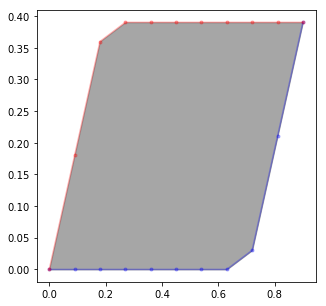

In [15]:
fig = plt.figure(figsize=(5, 5))
plt.plot(X, L_T, 'b.-', alpha=0.3)
plt.plot(X, U_T, 'r.-', alpha=0.3)
plt.fill_between(X, L_T, U_T, color= 'gray', alpha=0.7)

## Generalized Mrs. and Mr. Gerber's Lemma

In [25]:
''' Helper Functions '''
# Binary Entropy Function
def hb(p):
    if p == 0 or p == 1:
        return 0
    else:
        return -p*np.log2(p)-(1-p)*np.log2(1-p)

# Binary Entropy Inverted Function
def hbv(h):
    f = lambda x: x**x * (1-x)**(1-x) - 2**(-h)
    return fsolve(f, 0)

# Complement Multiplication Operator
def star(a, b):
    return (1-a)*b+(1-b)*a

# Mr./Mrs. Gerber's Lemma
def MSGL_L(x, delta):
    return hb(star(delta, hbv(x)))
def MSGL_U(x, delta, q):
    f = lambda a: x- a*hb(q/max(a, 2*q))
    a = fsolve(f, 0.5)
    return a*hb(star(q/max(a, 2*q), delta)) + (1-a)*hb(delta)

# Renyi Entropy
def Hb(b, P_X):
    sum_ = 0
    for i in range(len(P_X)):
        sum_ = sum_ + P_X[i]**b
    return 1/(1-b)*np.log(sum_)
def Kb(b, P_X):
    return np.exp((1-b)/b*Hb(b, P_X))

# Generalized Mr./Mrs. Gerber's Lemma
def GMRGL(x, q, delta, b):
    f = lambda a: Kb(b, [a, 1-a])-x
    p = fsolve(f, 0.5)
    return Kb(b, [star(p, delta), star(1-p, delta)])
def GMSGL(x, q, delta, b):
    f = lambda a: (1-a) + a*Kb(b, [q/max(a, 2*q), 1-q/max(a, 2*q)]) - x
    a = fsolve(f, 0.5)
    return a*Kb(b, [star(q/max(a, 2*q), delta), 1-star(q/max(a, 2*q), delta)]) + (1-a)*Kb(b, [delta, 1-delta])

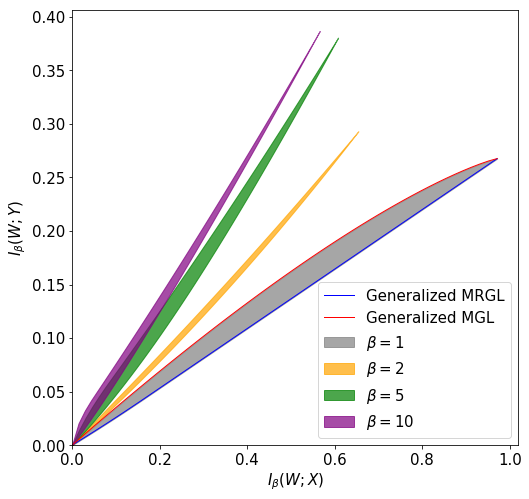

In [26]:
''' Setting Up '''
# Pr(X=1) = q
q = 0.4
# Crossover Probability \delta
delta = 0.2
# Order
B = [2, 5, 10]
# Resolution of the Image
n_sample = 51

P_X = [q, 1-q]
P_Y = [star(q, delta), star(1-q, delta)]
Ib_XW, Ib_YW_min, Ib_YW_max = \
     np.zeros((len(B)+1, n_sample)), np.zeros((len(B)+1, n_sample)), np.zeros((len(B)+1, n_sample))

figure_description = 'BSC_MGL.eps'

''' Mr./Mrs. Gerber's Lemma '''
H_X = np.linspace(0, hb(q), n_sample)    
for i in range(n_sample):
    x = H_X[i]
    Ib_XW[0][i] = hb(q) - x
    Ib_YW_min[0][i] = hb(star(q, delta)) - MSGL_U(x, delta, q)
    Ib_YW_max[0][i] = hb(star(q, delta)) - MSGL_L(x, delta)
    
plt.figure(figsize=(8, 8))
matplotlib.rcParams.update({'font.size': 15})
plt.plot(Ib_XW[0, :], Ib_YW_min[0, :], 'b-', linewidth=1, label='Generalized MRGL')
plt.plot(Ib_XW[0, :], Ib_YW_max[0, :], 'r-', linewidth=1, label='Generalized MGL')
plt.fill_between(Ib_XW[0, :], Ib_YW_min[0, :], Ib_YW_max[0, :], color='gray', label=r'$\beta = $%d'%1, alpha=0.7)
    
''' Generalized Mr./Mrs. Gerber's Lemma '''
C = ['orange', 'green', 'purple']
for j in range(1, len(B)+1):
    b = B[j-1]
    Hb_X = Hb(b, P_X)
    Hb_Y = Hb(b, P_Y)
    Kb_XgW = np.linspace(Kb(b, P_X), 1, n_sample)
    for i in range(n_sample):
        x = Kb_XgW[i]
        Ib_XW[j][i] = Hb_X - b/(1-b)*np.log(x)
        Ib_YW_min[j][i] = Hb_Y - b/(1-b)*np.log(GMRGL(x, q, delta, b)[0])
        Ib_YW_max[j][i] = Hb_Y - b/(1-b)*np.log(GMSGL(x, q, delta, b)[0])

#     plt.plot(Ib_XW[j, :], Ib_YW_min[j, :], 'b-', linewidth=1)
#     plt.plot(Ib_XW[j, :], Ib_YW_max[j, :], 'r-', linewidth=1)
    plt.fill_between(Ib_XW[j, :], Ib_YW_min[j, :], Ib_YW_max[j, :], color=C[j-1], label=r'$\beta = $%d'%b, alpha=0.7)

plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel(r'$I_\beta(W; X)$', fontsize = 15)
plt.ylabel(r'$I_\beta(W; Y)$', fontsize = 15)
plt.legend(loc='lower right', fontsize=15)
plt.savefig('Figures/%s'%figure_description, format='eps', dpi=1000)

## Integrate All the Figures

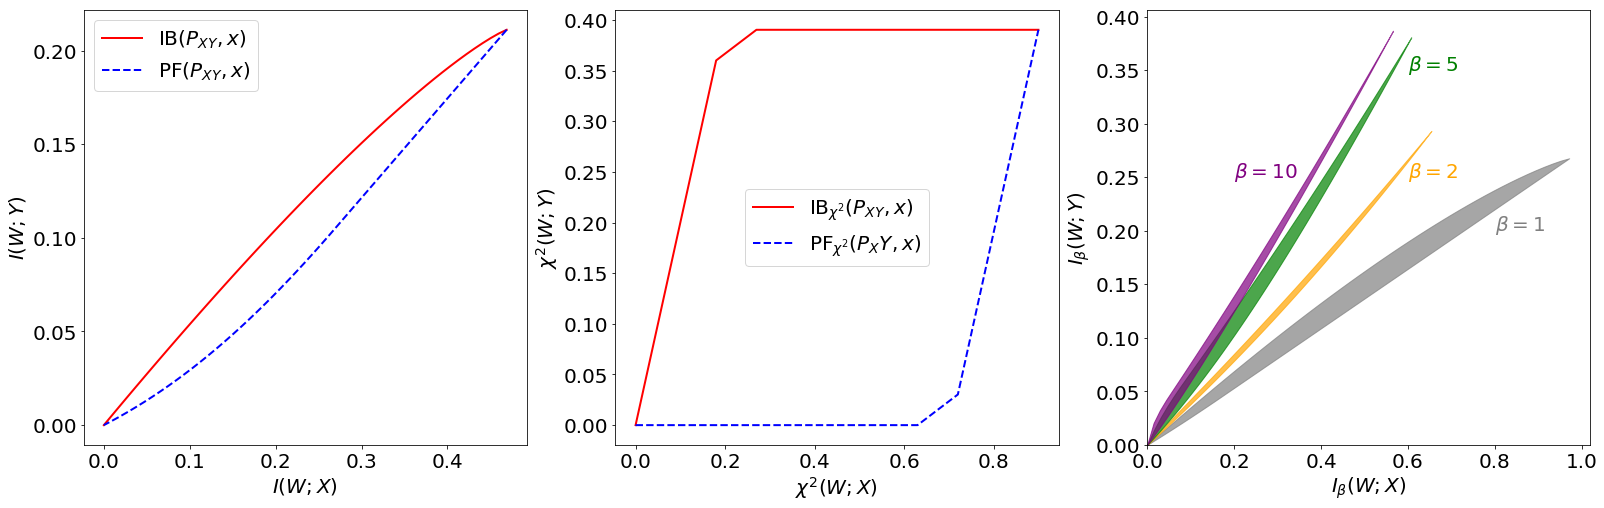

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(27, 8))
fontsize = 20
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

figure_description = 'ISIT18.eps'

ax[0].plot(I_WX, I_WY_max, 'r-', linewidth=linewidth, label=r'$\mathsf{IB}(P_{XY}, x)$')
ax[0].plot(I_WX, I_WY_min, 'b--', linewidth=linewidth, label=r'$\mathsf{PF}(P_{XY}, x)$')
ax[0].set_xlabel('$I(W; X)$', fontsize = fontsize)
ax[0].set_ylabel('$I(W; Y)$', fontsize = fontsize)
ax[0].legend(loc='best', fontsize=fontsize)

ax[1].plot(X, U_T, 'r-', linewidth=linewidth, label=r'$\mathsf{IB}_{\chi^2}(P_{XY}, x)$')
ax[1].plot(X, L_T, 'b--', linewidth=linewidth, label=r'$\mathsf{PF}_{\chi^2}(P_XY, x)$')
ax[1].set_xlabel(r'$\chi^2(W; X)$', fontsize = fontsize)
ax[1].set_ylabel(r'$\chi^2(W; Y)$', fontsize = fontsize)
ax[1].legend(loc='best', fontsize=fontsize)

# ax[2].plot(Ib_XW[0, :], Ib_YW_min[0, :], 'b-', linewidth=2, label='Generalized MRGL')
# ax[2].plot(Ib_XW[0, :], Ib_YW_max[0, :], 'r-', linewidth=2, label='Generalized MGL')
ax[2].fill_between(Ib_XW[0, :], Ib_YW_min[0, :], Ib_YW_max[0, :], color='gray', label=r'$\beta = $%d'%1, alpha=0.7)
for j in range(1, len(B)+1):
    b = B[j-1]
    ax[2].fill_between(Ib_XW[j, :], Ib_YW_min[j, :], Ib_YW_max[j, :], color=C[j-1], label=r'$\beta = $%d'%b, alpha=0.7)
ax[2].set_xlim(xmin=0)
ax[2].set_ylim(ymin=0)
ax[2].set_xlabel(r'$I_\beta(W; X)$', fontsize = fontsize)
ax[2].set_ylabel(r'$I_\beta(W; Y)$', fontsize = fontsize)
# ax[2].legend(loc='lower right', fontsize=15)
ax[2].text(0.2, 0.25, r'$\beta=10$', color='purple')
ax[2].text(0.6, 0.35, r'$\beta=5$', color='green')
ax[2].text(0.6, 0.25, r'$\beta=2$', color='orange')
ax[2].text(0.8, 0.20, r'$\beta=1$', color='gray')
plt.savefig('Figures/%s'%figure_description, format='eps', dpi=1000, bbox_inches='tight')